# Fitting allosteric parameters



In [1]:
%%capture
%run receptor_tools.ipynb
import numpy as np
import random
from matplotlib import pyplot as plt

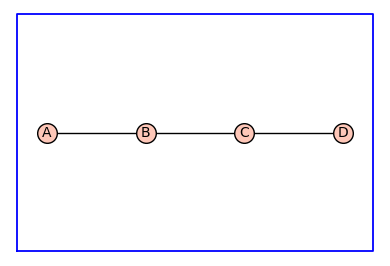

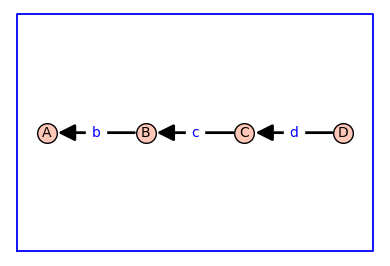

\(1\),\(2 \kappa_{\mathit{b}}\),\(2 \kappa_{\mathit{b}} \kappa_{\mathit{c}}\),\(2 \kappa_{\mathit{b}} \kappa_{\mathit{c}} \kappa_{\mathit{d}}\)
\(0\),\(\kappa_{\mathit{b}}^{2} \eta_{\mathit{bb}}\),\(2 \kappa_{\mathit{b}}^{2} \kappa_{\mathit{c}} \eta_{\mathit{bb}} \eta_{\mathit{bc}}\),\(2 \kappa_{\mathit{b}}^{2} \kappa_{\mathit{c}} \kappa_{\mathit{d}} \eta_{\mathit{bb}} \eta_{\mathit{bc}} \eta_{\mathit{bd}}\)
\(0\),\(0\),\(\kappa_{\mathit{b}}^{2} \kappa_{\mathit{c}}^{2} \eta_{\mathit{bb}} \eta_{\mathit{bc}}^{2} \eta_{\mathit{cc}}\),\(2 \kappa_{\mathit{b}}^{2} \kappa_{\mathit{c}}^{2} \kappa_{\mathit{d}} \eta_{\mathit{bb}} \eta_{\mathit{bc}}^{2} \eta_{\mathit{cc}} \eta_{\mathit{bd}} \eta_{\mathit{cd}}\)
\(0\),\(0\),\(0\),\(\kappa_{\mathit{b}}^{2} \kappa_{\mathit{c}}^{2} \kappa_{\mathit{d}}^{2} \eta_{\mathit{bb}} \eta_{\mathit{bc}}^{2} \eta_{\mathit{cc}} \eta_{\mathit{bd}}^{2} \eta_{\mathit{cd}}^{2} \eta_{\mathit{dd}}\)


In [2]:
#G = graphs.HouseGraph()
G = graphs.PathGraph(4)

(G, T, KappaEta, A) = enumerate_allosteric_parameters(G,method='alpha',show=True)

In [3]:
n_states=G.order()
n_kappa=n_states-1
n_kappa_plus_eta = A.ngens()
n_eta=n_kappa_plus_eta-n_kappa
kappa_list = [A.gen(k) for k in range(n_kappa)]
print(f'kappa_list = {kappa_list}\n')

eta_list = [A.gen(k) for k in range(n_kappa,n_kappa_plus_eta)]
print(f'eta_list = {eta_list}\n')

phi=normalize(random_binary_array(n_states))
print(f'phi = {phi}\n')

Phi = dimerize(phi)
print(f'Phi = {Phi}\n')
#print(f'KappaEta = {KappaEta}\n')

kappa_list = [kappa_b, kappa_c, kappa_d]

eta_list = [eta_bb, eta_bc, eta_cc, eta_bd, eta_cd, eta_dd]

phi = [0.33333333 0.         0.33333333 0.33333333]

Phi = [[0.2222222222222222, 0.0, 0.1111111111111111, 0.1111111111111111], [0, 0.0, 0.0, 0.0], [0, 0, 0.2222222222222222, 0.1111111111111111], [0, 0, 0, 0.2222222222222222]]



In [4]:
# create the symbolic binding curve 
FBindingKappaEta=make_symbolic_dimer_binding_curve(Phi,KappaEta)
show(FBindingKappaEta)

(0.2222222222222222*kappa_b^2*kappa_c^2*kappa_d^2*eta_bb*eta_bc^2*eta_cc*eta_bd^2*eta_cd^2*eta_dd + 0.2222222222222222*kappa_b^2*kappa_c^2*kappa_d*eta_bb*eta_bc^2*eta_cc*eta_bd*eta_cd + 0.2222222222222222*kappa_b^2*kappa_c^2*eta_bb*eta_bc^2*eta_cc + 0.2222222222222222*kappa_b*kappa_c*kappa_d + 0.2222222222222222*kappa_b*kappa_c + 0.2222222222222222)/(kappa_b^2*kappa_c^2*kappa_d^2*eta_bb*eta_bc^2*eta_cc*eta_bd^2*eta_cd^2*eta_dd + 2.0*kappa_b^2*kappa_c^2*kappa_d*eta_bb*eta_bc^2*eta_cc*eta_bd*eta_cd + kappa_b^2*kappa_c^2*eta_bb*eta_bc^2*eta_cc + 2.0*kappa_b^2*kappa_c*kappa_d*eta_bb*eta_bc*eta_bd + 2.0*kappa_b^2*kappa_c*eta_bb*eta_bc + 2.0*kappa_b*kappa_c*kappa_d + kappa_b^2*eta_bb + 2.0*kappa_b*kappa_c + 2.0*kappa_b + 1.0)

In [5]:
# add ligand dependencies randomly or manually
manual = False
var('X')
if manual:
    d_kappa_X = dict({kappa_b: kappa_b*X, kappa_c: kappa_c*X})
else:
    def Round_To_n(x, n):
        return round(x, -int(np.floor(np.sign(x) * np.log10(abs(x)))) + n)
    d_kappa_X=dict()
    num_X = 0
    while num_X == 0: # make sure there is at least one ligand binding edge (kappa*X)
        for kappa in kappa_list:
            k=Round_To_n(np.random.exponential(scale=1.0),2)
            ligand_prob = 0.4
            if np.random.random() <= ligand_prob:
                d_kappa_X[kappa]=k*X
                num_X += 1
            else:
                d_kappa_X[kappa]=k
print(d_kappa_X)
FBindingEtaX=FBindingKappaEta.subs(d_kappa_X)
show(FBindingEtaX)

{kappa_b: 0.793, kappa_c: 0.971*X, kappa_d: 0.029*X}


(0.00011080728565057089*X^4*eta_bb*eta_bc^2*eta_bd^2*eta_cc*eta_cd^2*eta_dd + 0.0038209408845024445*X^3*eta_bb*eta_bc^2*eta_bd*eta_cc*eta_cd + 0.1317565822242222*X^2*eta_bb*eta_bc^2*eta_cc + 0.004962241555555556*X^2 + 0.17111177777777778*X + 0.2222222222222222)/(0.0004986327854275691*X^4*eta_bb*eta_bc^2*eta_bd^2*eta_cc*eta_cd^2*eta_dd + 0.034388467960522*X^3*eta_bb*eta_bc^2*eta_bd*eta_cc*eta_cd + 0.592904620009*X^2*eta_bb*eta_bc^2*eta_cc + 0.03541551798200001*X^2*eta_bb*eta_bc*eta_bd + 1.2212247580000002*X*eta_bb*eta_bc + 0.044660174000000004*X^2 + 1.540006*X + 0.6288490000000001*eta_bb + 2.5860000000000003)

In [6]:
FastCallableFBindingEtaX = fast_callable(FBindingEtaX, vars=['X']+eta_list)

In [7]:
from scipy.optimize import minimize
import random
from matplotlib import pyplot as plt

# construct target function
# xrange and values x for data, x0 for smooth plots
xlogmin=-3
xlogmax=3
x = np.logspace(xlogmin,xlogmax,20)
x0 = np.logspace(xlogmin,xlogmax,1000)


# choose random eta's with 50% chance of being 1 (1 means that this eta is unused)
eta_prob_one = 0.5
eta = np.random.exponential(scale=1.0,size=n_eta)
for i in range(n_eta):
    if np.random.random() <= eta_prob_one:
        eta[i]=1.0
y = FastCallableFBindingEtaX(x,*eta) + np.random.normal(size=x.size, scale=0.005) # w/ noise
y0 = FastCallableFBindingEtaX(x0,*eta) # y, y0 are large arrays 

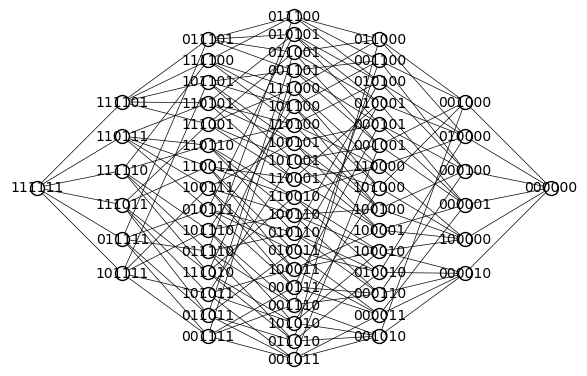

In [8]:
# create hypercube and flip left/right
Q = graphs.CubeGraph(n_eta, embedding=2)
pos = Q.get_pos()
for v in Q.vertices(sort=False):
    xpos,ypos = pos[v] # do not use x,y here! These are needed below
    pos[v]=(n_eta-xpos,ypos)
    # pos[v]=(ypos,xpos) this didn't look good 
Q.show(figsize=6,edge_labels=False,vertex_labels=True, vertex_size=100,edge_thickness=0.5,vertex_colors='white')

In [9]:
root = "1" * n_eta
d_level = dict()
for level in range(n_eta+1):
    for v in Q.vertices(sort=True):
        if level == Q.distance(v,root):
            d_level[v]=level
print(d_level)

{'111111': 0, '011111': 1, '101111': 1, '110111': 1, '111011': 1, '111101': 1, '111110': 1, '001111': 2, '010111': 2, '011011': 2, '011101': 2, '011110': 2, '100111': 2, '101011': 2, '101101': 2, '101110': 2, '110011': 2, '110101': 2, '110110': 2, '111001': 2, '111010': 2, '111100': 2, '000111': 3, '001011': 3, '001101': 3, '001110': 3, '010011': 3, '010101': 3, '010110': 3, '011001': 3, '011010': 3, '011100': 3, '100011': 3, '100101': 3, '100110': 3, '101001': 3, '101010': 3, '101100': 3, '110001': 3, '110010': 3, '110100': 3, '111000': 3, '000011': 4, '000101': 4, '000110': 4, '001001': 4, '001010': 4, '001100': 4, '010001': 4, '010010': 4, '010100': 4, '011000': 4, '100001': 4, '100010': 4, '100100': 4, '101000': 4, '110000': 4, '000001': 5, '000010': 5, '000100': 5, '001000': 5, '010000': 5, '100000': 5, '000000': 6}


In [10]:
def do_eta_fit(eta_list):

    # Define the objective function
    def objective_function(params):
        eta = params
        residuals = y - FastCallableFBindingEtaX(x,*eta)
        return np.sum(residuals ** 2)

    # Initial guess for parameters
    initial_guess = np.ones(n_eta)
    # this loop makes elements of the tuple bnds
    bnds = ()
    k = 0 # nparams
    for i in range(n_eta):
        if eta_list[i]==1.0:
            bnds += ((1, 1),) # eta = 1, not used
        else:
            bnds += ((0, None),) # eta non-negative
            k += 1

    # Perform optimization
    result = minimize(objective_function, initial_guess, bounds=bnds)

    # Extract and print optimized eta's
    optimal_eta = result.x
    np.set_printoptions(precision=2)
    print( optimal_eta )
    #print(f'{optimal_eta=}')

    # Evaluate result
    y0_result = FastCallableFBindingEtaX(x0,*optimal_eta)

    res = y - FastCallableFBindingEtaX(x,*optimal_eta)
    ssr = np.sum(res ** 2)
    n = len(y)
    aic = 2*(k+2)+n*np.log(ssr/(n-k))

    # Plot result
    plot_results = True
    if plot_results:
        plt.semilogx(x0,y0,linewidth=4,color='yellow',label='exact')
        plt.semilogx(x,y,'+',color='black',label='sim data')
        plt.semilogx(x0,y0_result,color='red',linestyle='dashed',label='fit')
        np.set_printoptions(precision=2)
        plt.title(f'aic={aic=},\ntarget eta={eta},\noptimal eta={optimal_eta}')
        plt.xlabel('x')
        plt.ylabel('phi',rotation = 0)
        plt.legend()
        plt.grid()
        plt.show()

    return aic

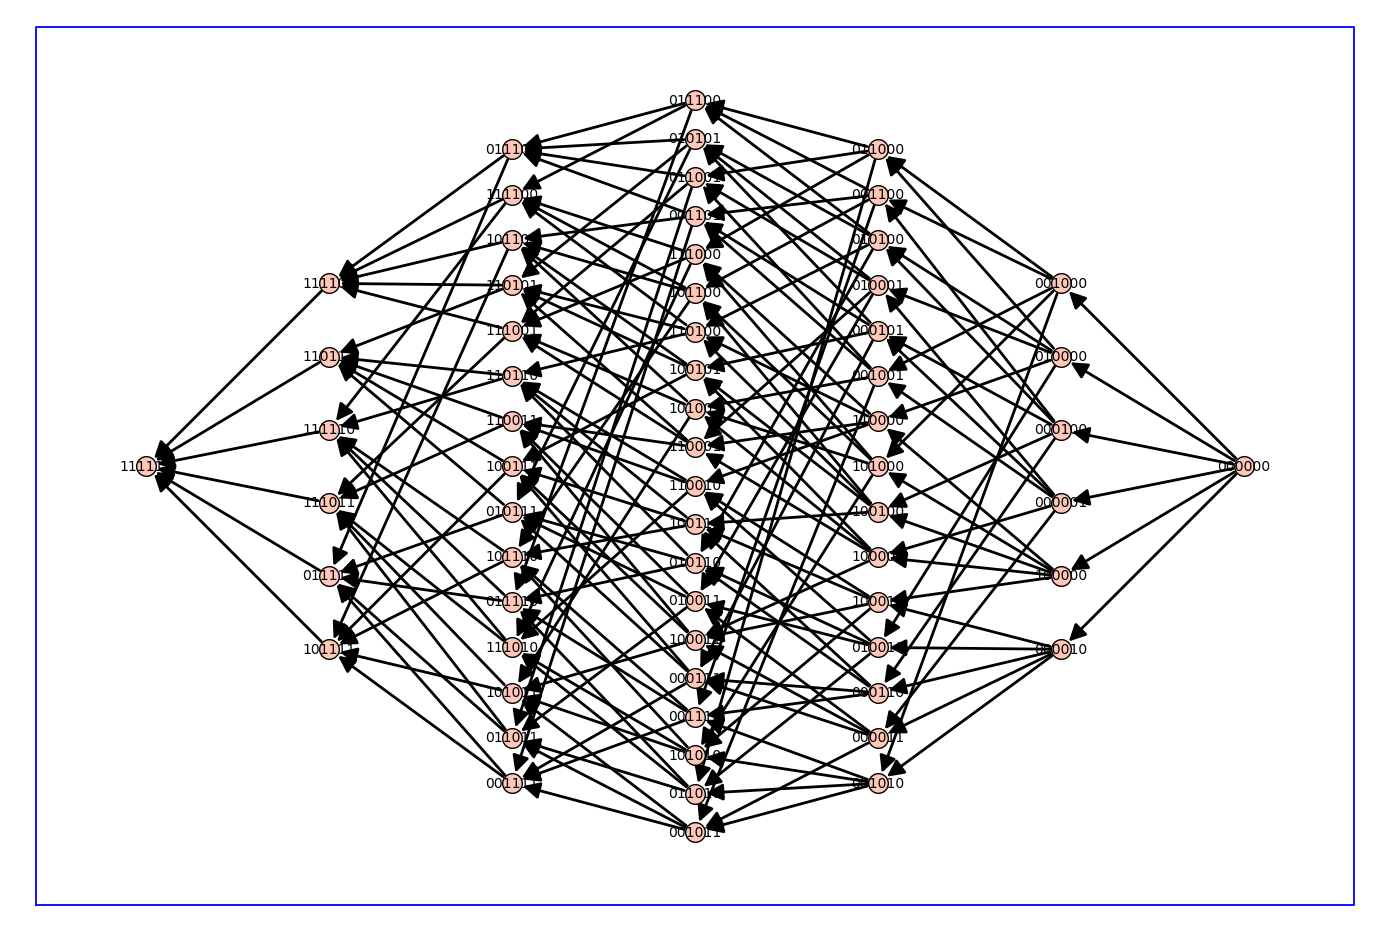

In [11]:
# make arcs point rightward to "lower" levels only (fewer parameters used, more 1's)
Q_directed = Q.to_directed()
for e in Q_directed.edges(sort=False):
    if d_level[e[0]]<d_level[e[1]]:
        Q_directed.delete_edge(e)
Q_directed.show(figsize=14,graph_border=True)

[1. 1. 1. 1. 1. 1.]


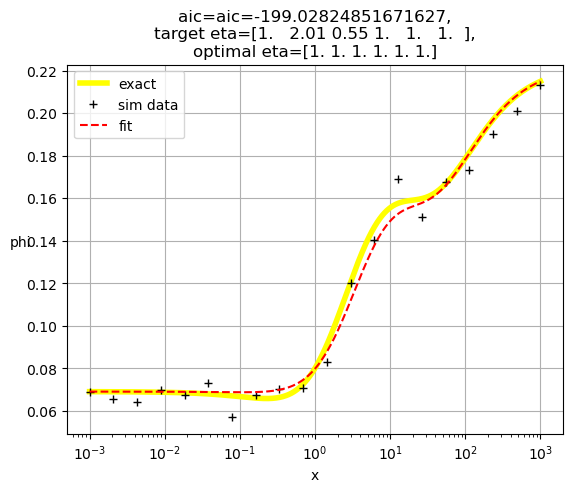

[1.22 1.   1.   1.   1.   1.  ]


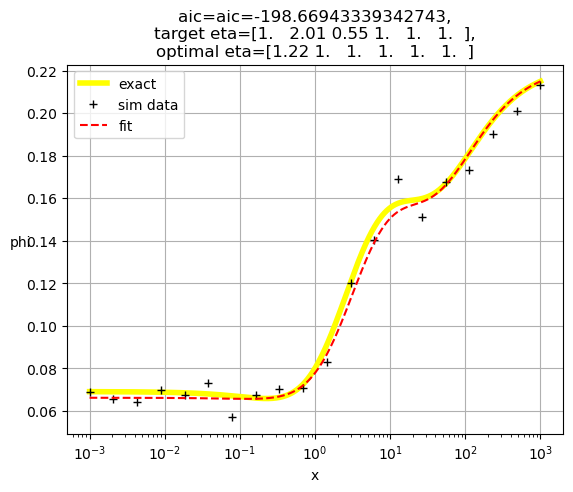

[1.   1.14 1.   1.   1.   1.  ]


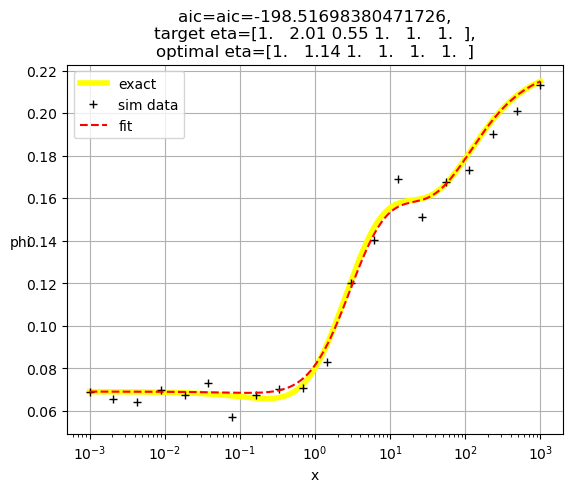

[1.   1.   1.16 1.   1.   1.  ]


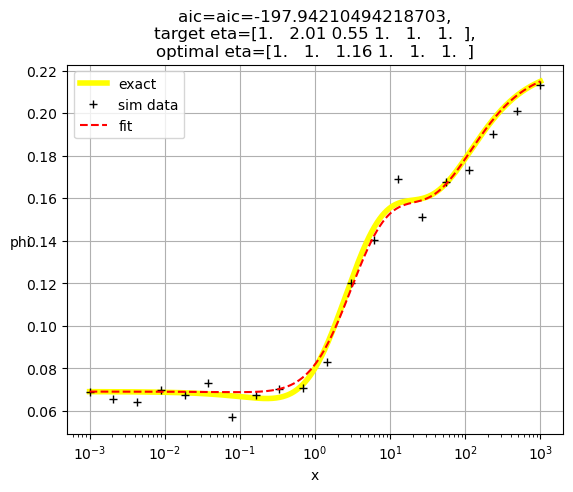

[1.   1.   1.   0.68 1.   1.  ]


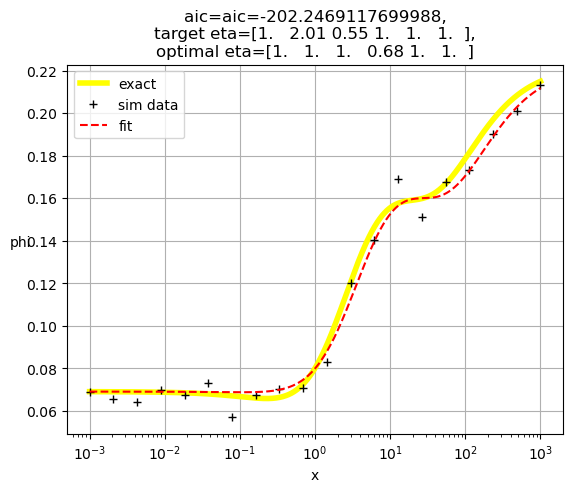

[1.   1.   1.   1.   0.69 1.  ]


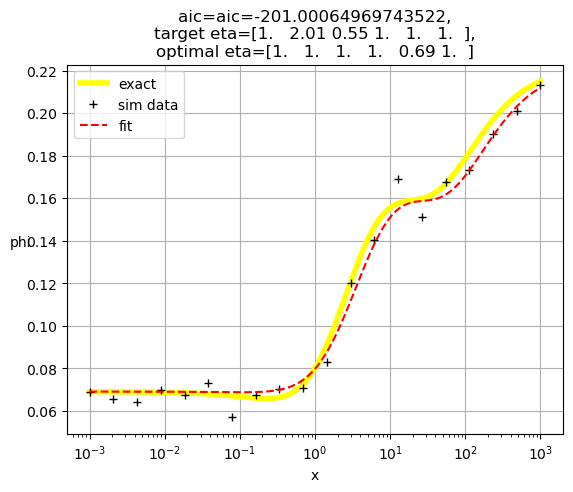

[1.   1.   1.   1.   1.   0.79]


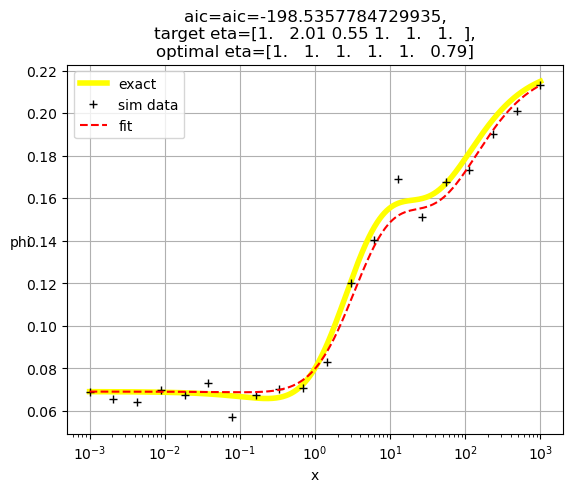

[1.19 1.12 1.   1.   1.   1.  ]


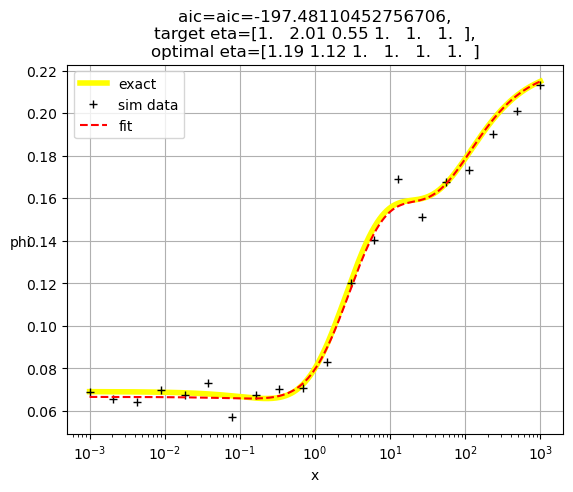

[1.21 1.   1.14 1.   1.   1.  ]


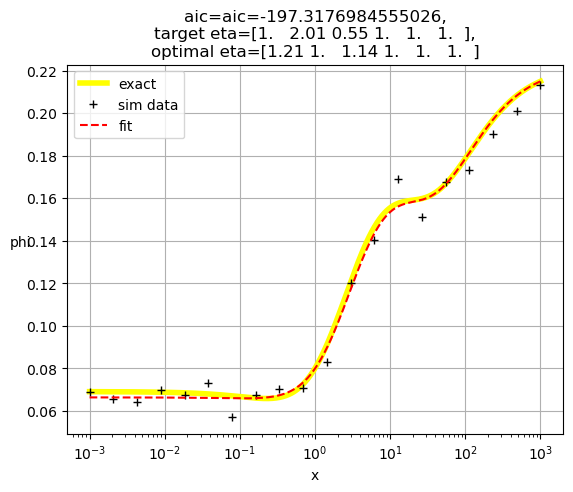

[1.21 1.   1.   0.68 1.   1.  ]


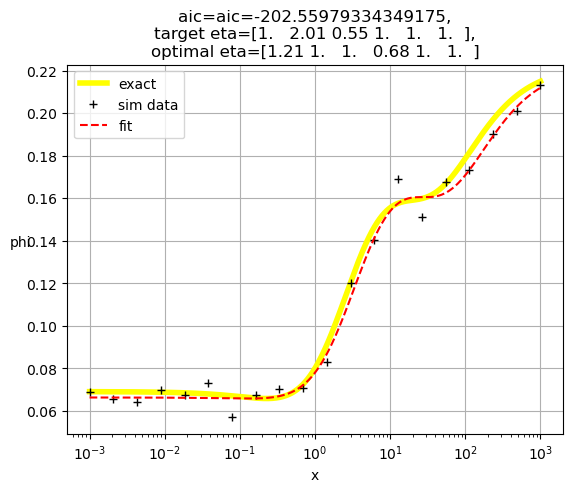

[1.22 1.   1.   1.   0.69 1.  ]


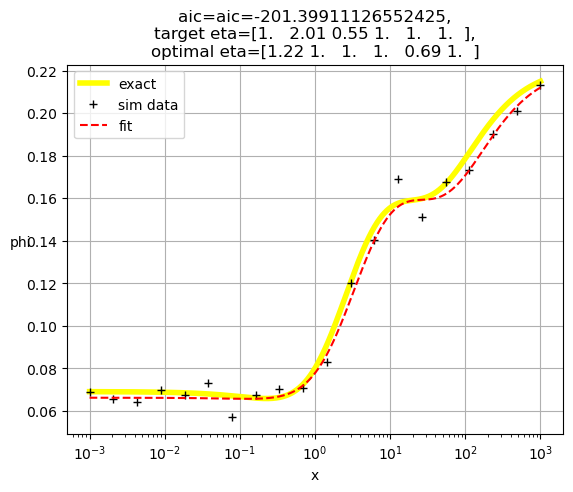

[1.23 1.   1.   1.   1.   0.78]


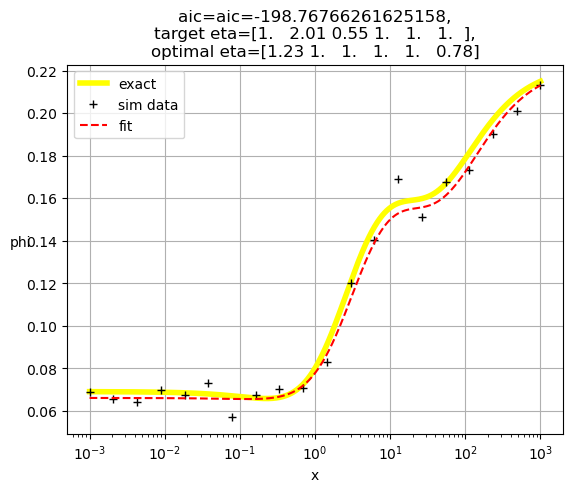

[1.   2.15 0.47 1.   1.   1.  ]


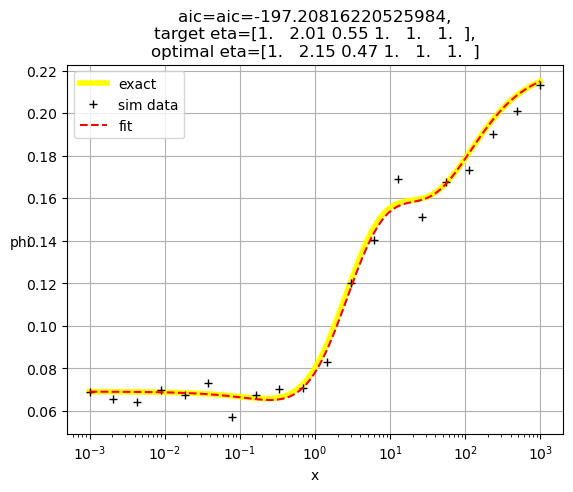

[1.  1.1 1.  0.7 1.  1. ]


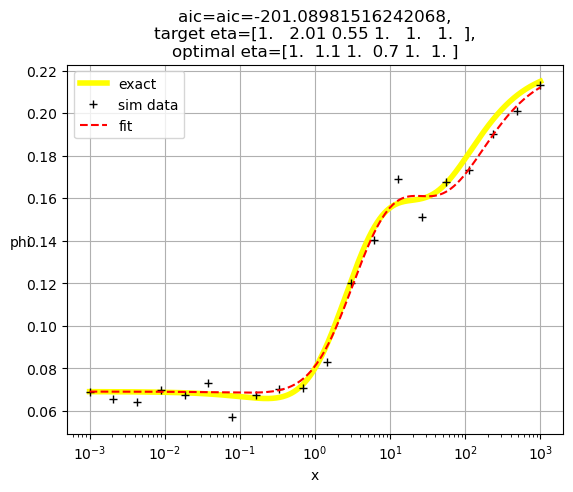

[1.   1.13 1.   1.   0.7  1.  ]


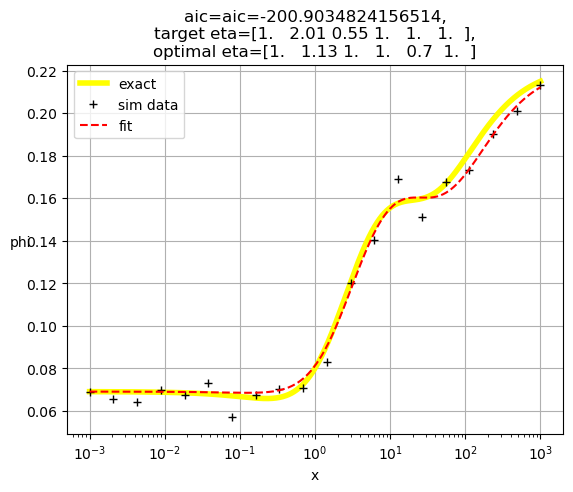

[1.   1.16 1.   1.   1.   0.76]


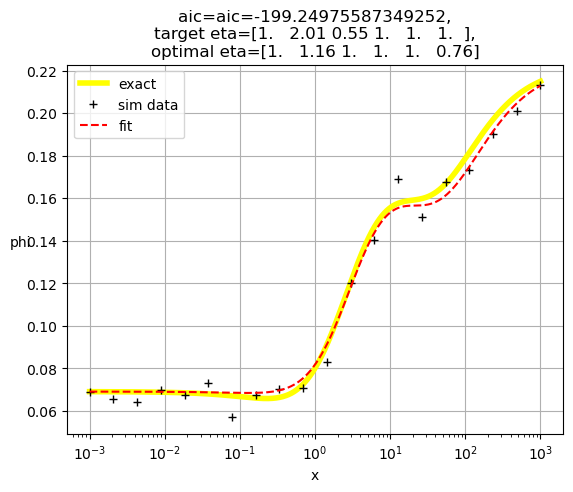

[1.   1.   1.11 0.7  1.   1.  ]


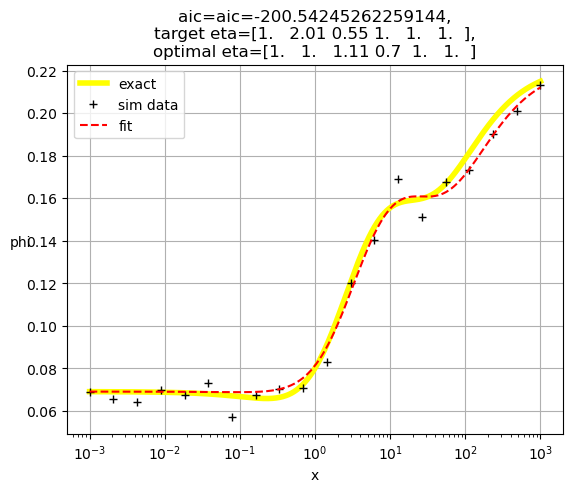

[1.   1.   1.15 1.   0.7  1.  ]


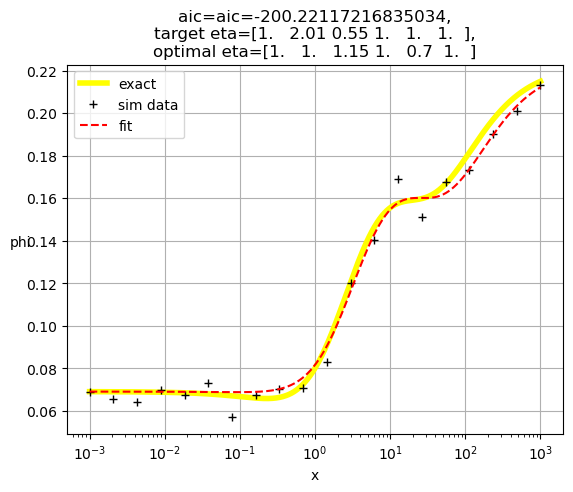

[1.   1.   1.19 1.   1.   0.76]


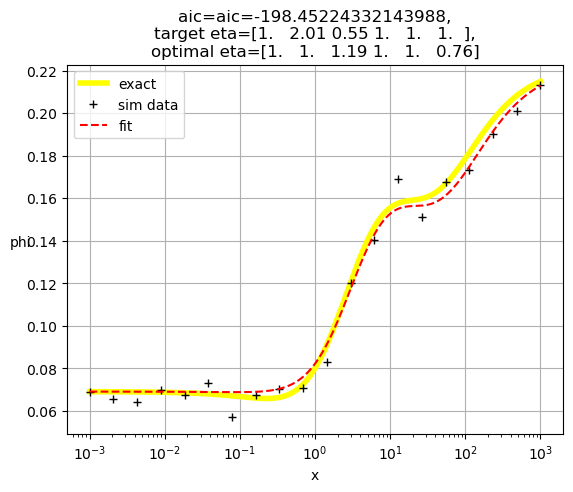

[1.   1.   1.   0.28 2.47 1.  ]


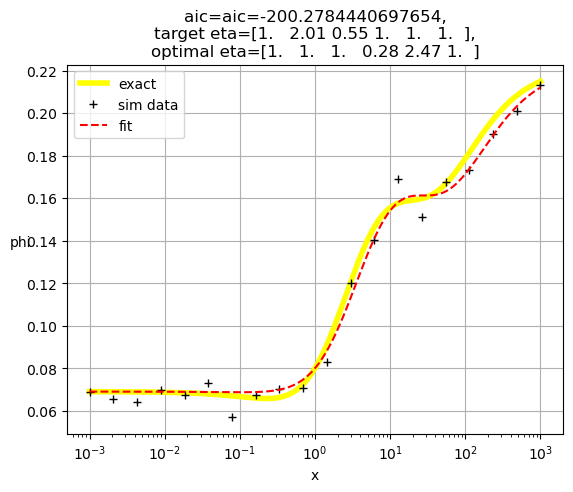

[1.   1.   1.   0.59 1.   1.16]


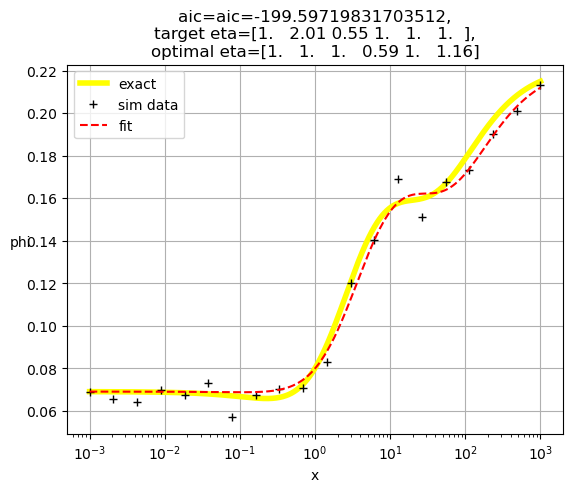

[1.   1.   1.   1.   0.54 1.28]


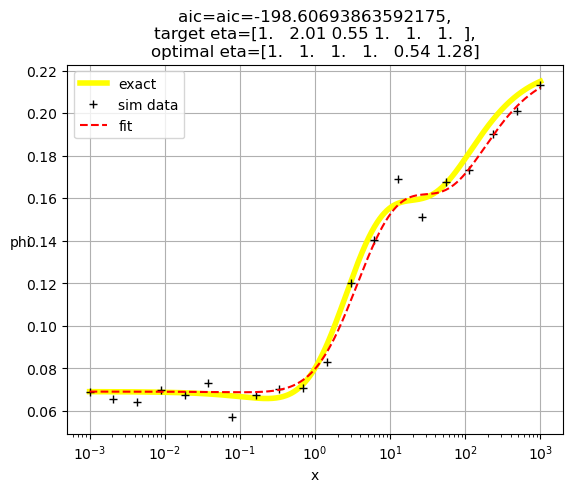

[1.13 1.56 0.67 1.   1.   1.  ]


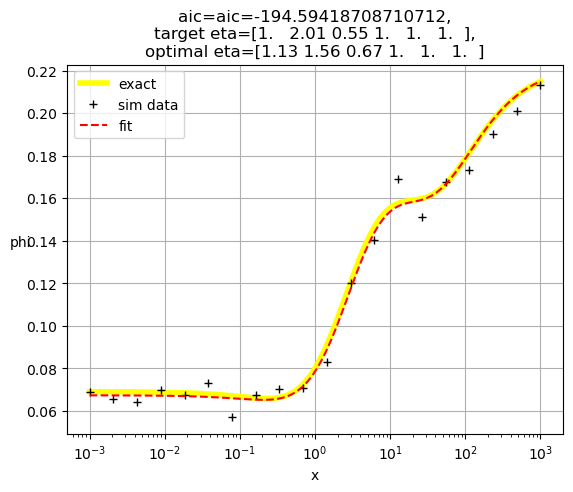

[1.19 1.08 1.   0.7  1.   1.  ]


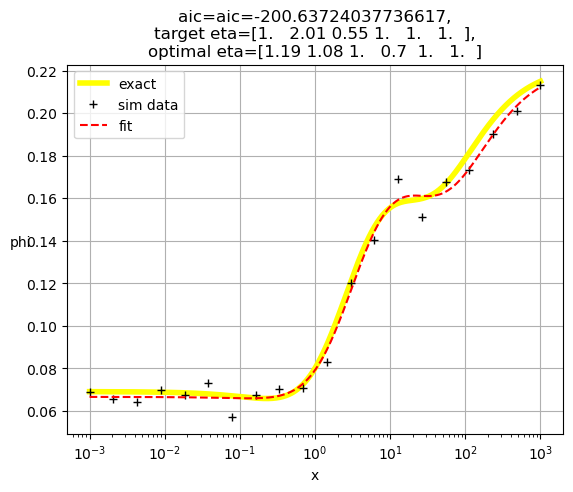

[1.19 1.1  1.   1.   0.7  1.  ]


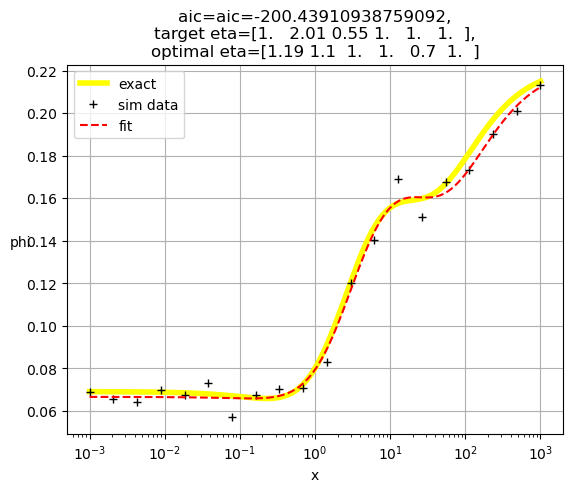

[1.19 1.13 1.   1.   1.   0.76]


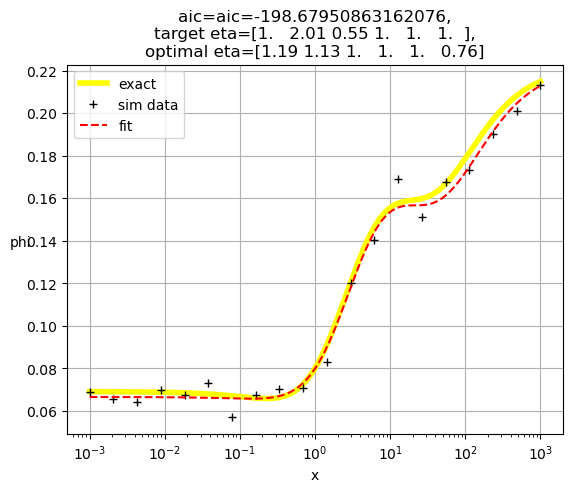

[1.2  1.   1.09 0.7  1.   1.  ]


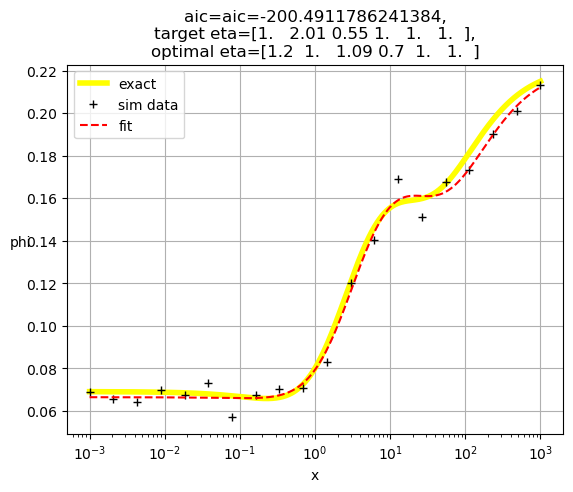

[1.21 1.   1.12 1.   0.7  1.  ]


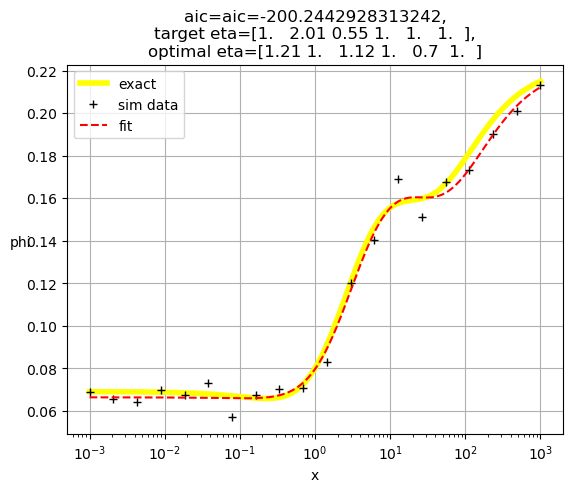

[1.21 1.   1.16 1.   1.   0.76]


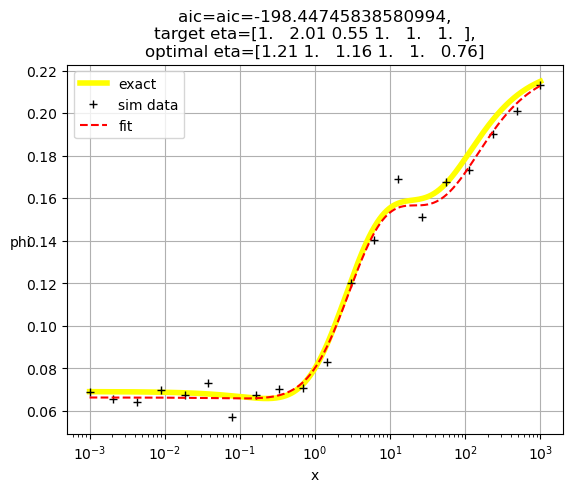

[1.2  1.   1.   0.26 2.68 1.  ]


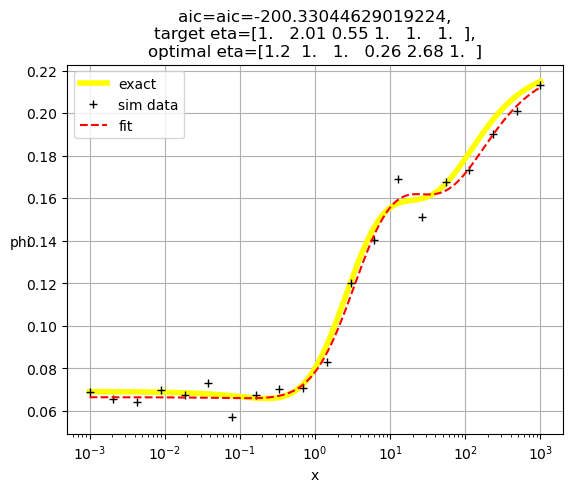

[1.21 1.   1.   0.63 1.   1.1 ]


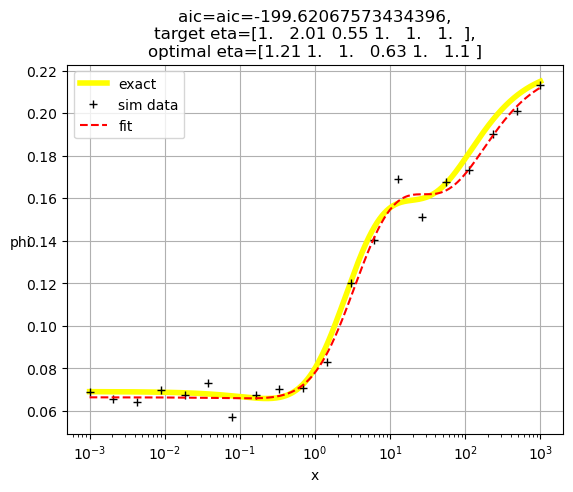

[1.22 1.   1.   1.   0.59 1.18]


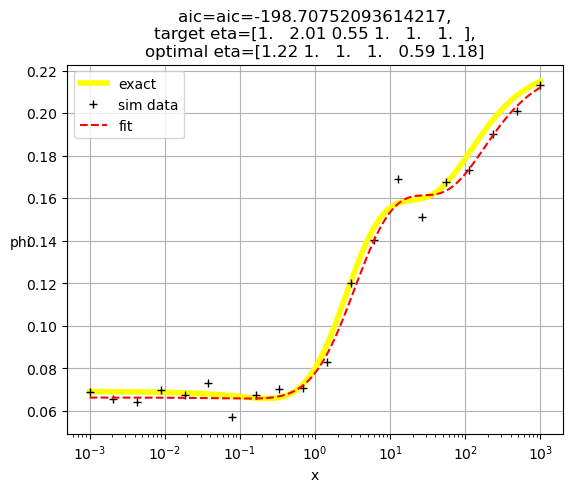

[1.   2.02 0.48 0.7  1.   1.  ]


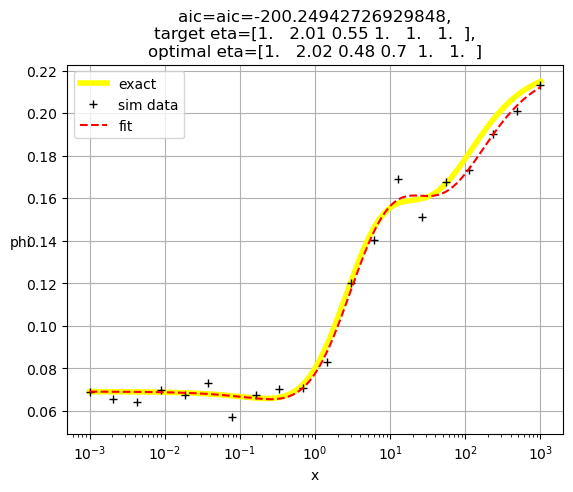

[1.   2.11 0.47 1.   0.7  1.  ]


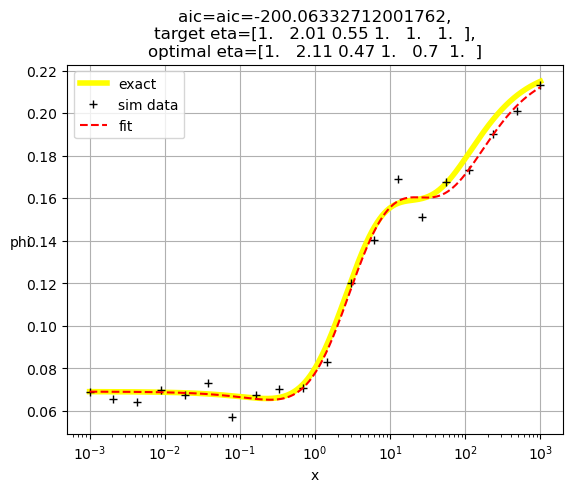

[1.   2.19 0.47 1.   1.   0.76]


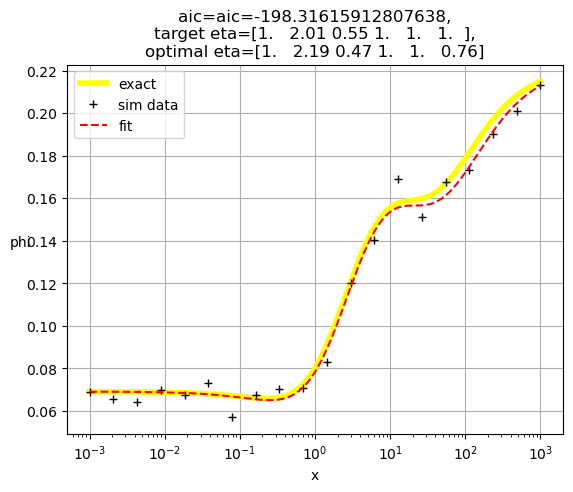

[1.   1.12 1.   0.83 0.85 1.  ]


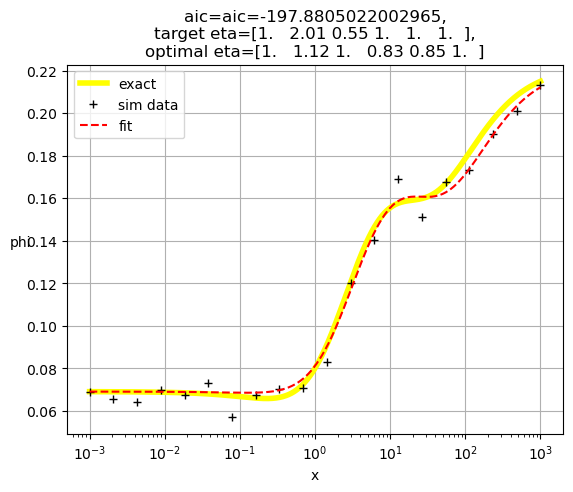

[1.   1.1  1.   0.7  1.   1.01]


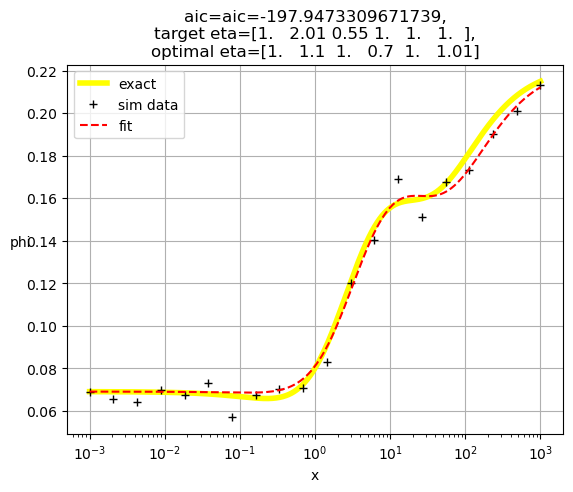

[1.   1.12 1.   1.   0.67 1.06]


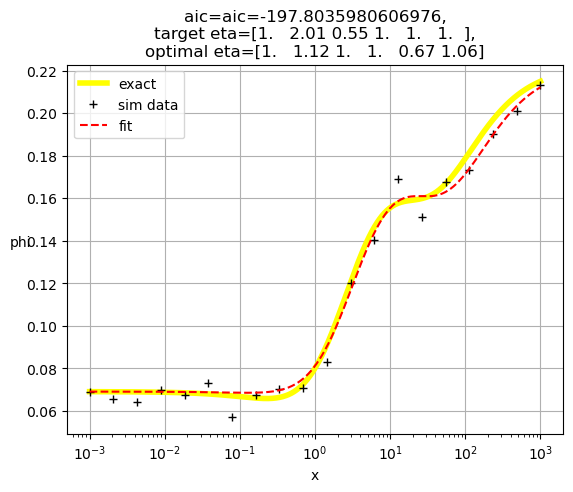

[1.   1.   1.06 0.21 3.41 1.  ]


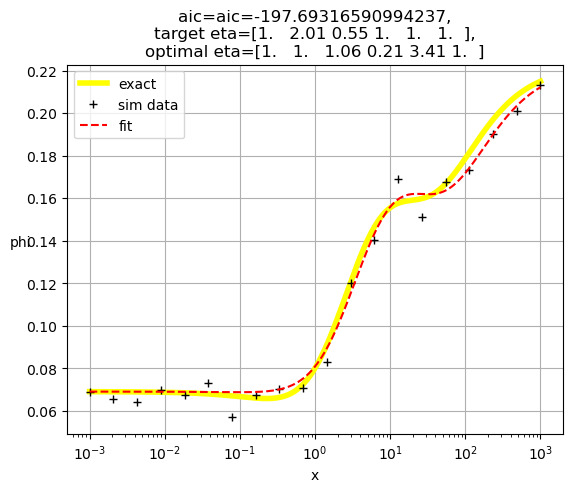

[1.   1.   1.11 0.67 1.   1.04]


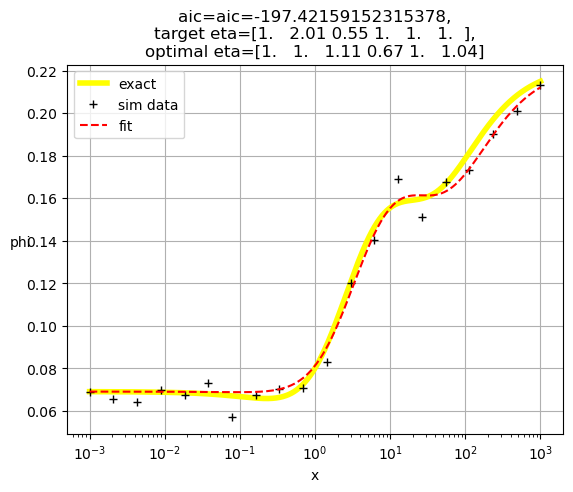

[1.   1.   1.13 1.   0.64 1.09]


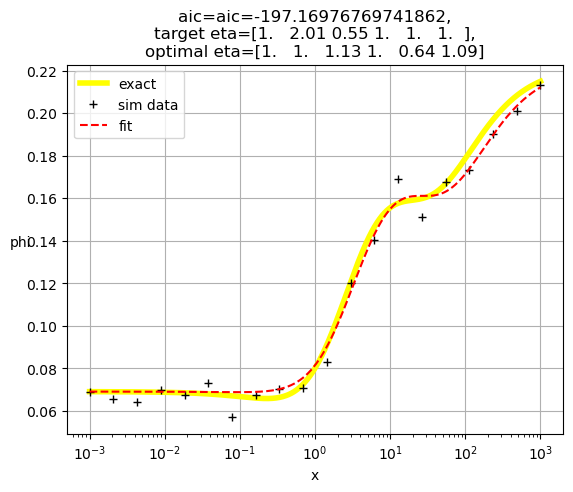

[1.   1.   1.   0.12 6.19 0.97]


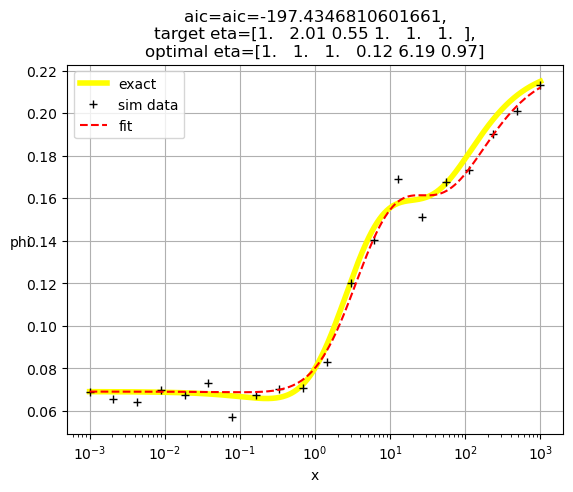

[1.13 1.49 0.68 0.7  1.   1.  ]


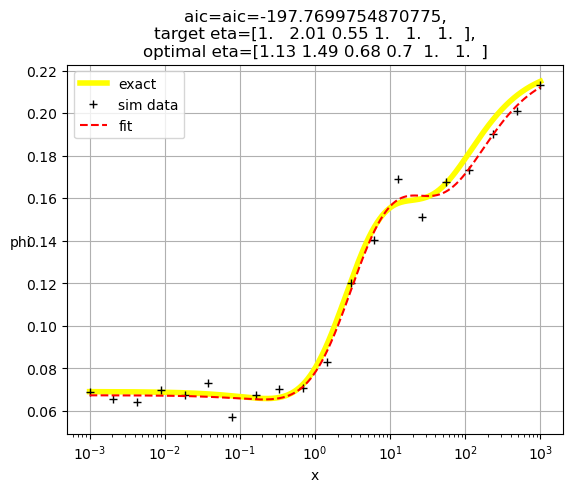

[1.13 1.52 0.68 1.   0.71 1.  ]


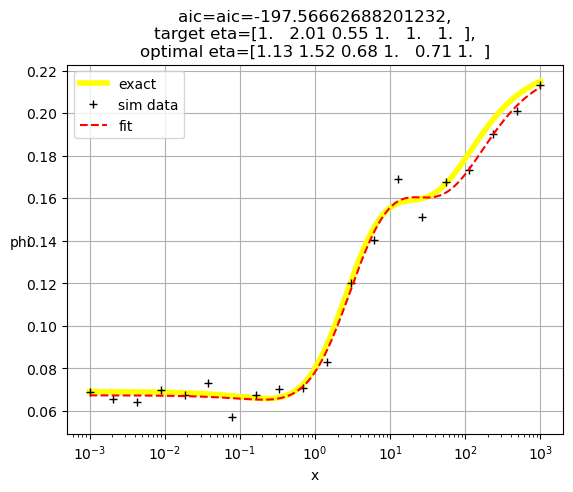

[1.13 1.58 0.67 1.   1.   0.76]


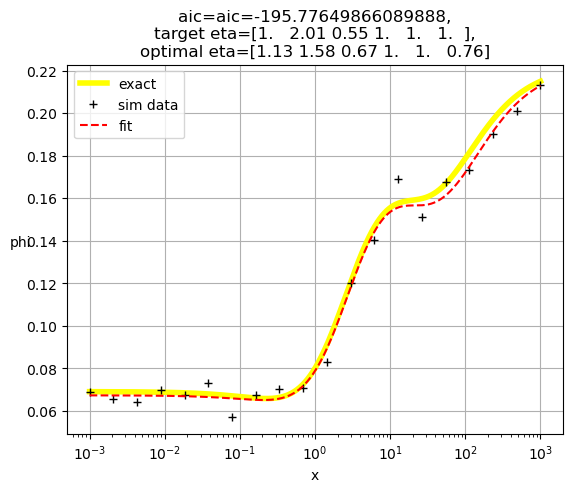

[1.19 1.09 1.   0.83 0.85 1.  ]


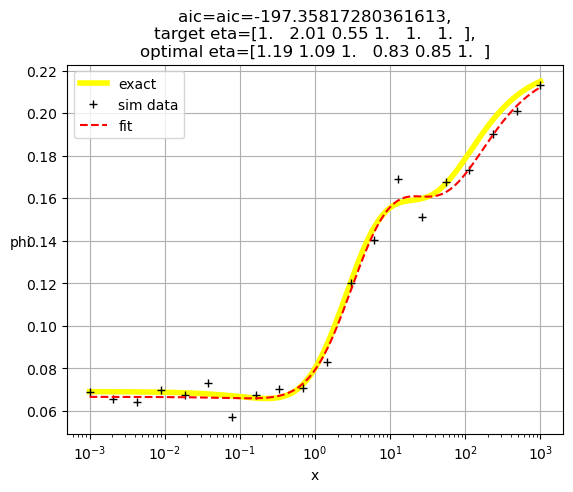

[1.19 1.08 1.   0.71 1.   0.99]


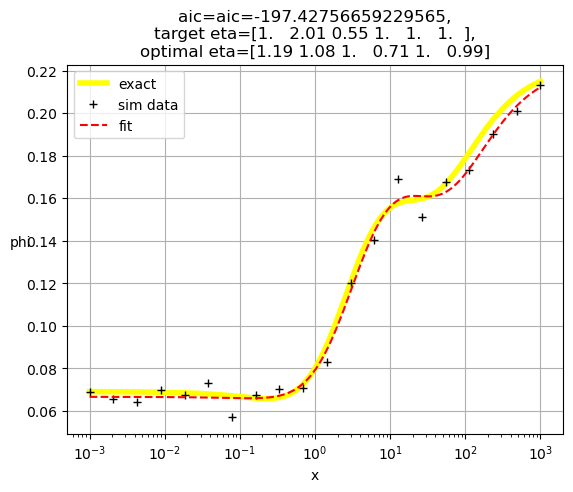

[1.19 1.1  1.   1.   0.68 1.04]


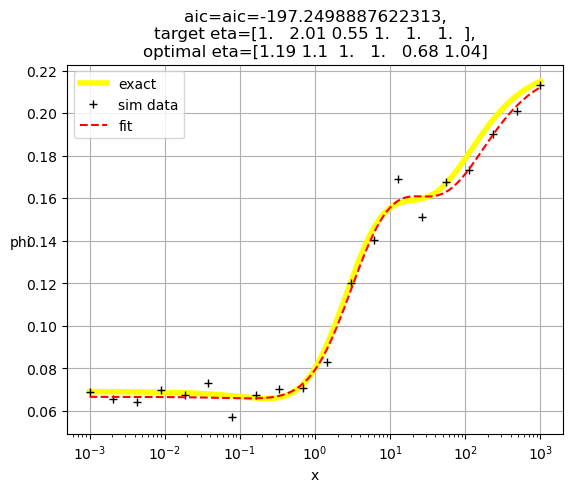

[1.21 1.   1.1  0.82 0.86 1.  ]


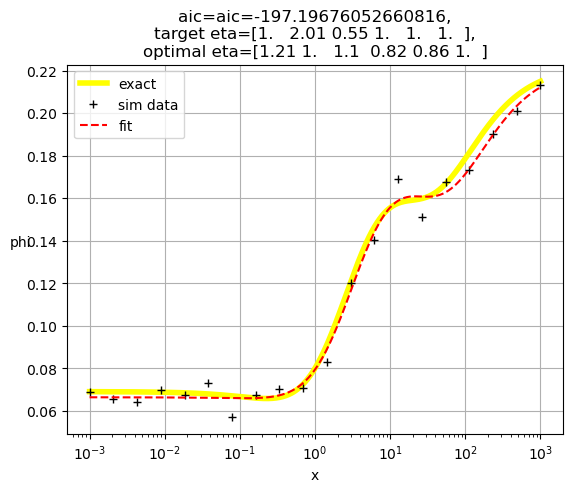

[1.2  1.   1.09 0.7  1.   1.  ]


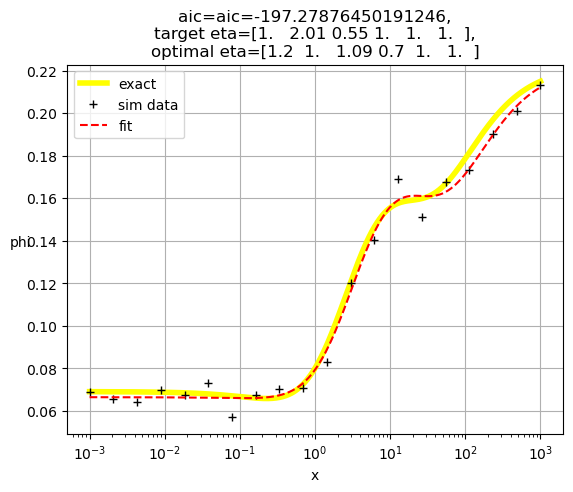

[1.2  1.   1.11 1.   0.67 1.05]


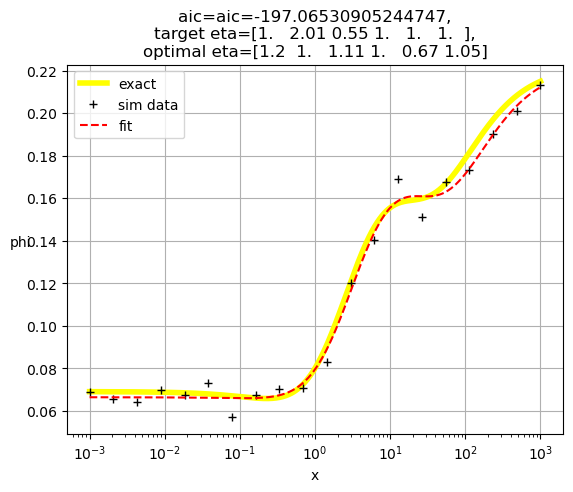

[1.2  1.   1.   0.12 6.4  0.92]


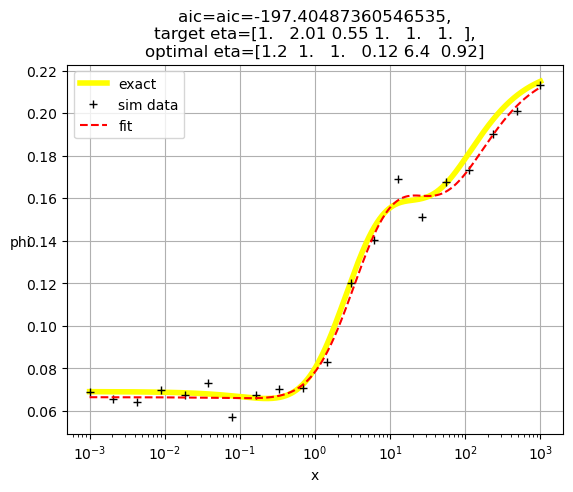

[1.   2.04 0.47 0.66 1.07 1.  ]


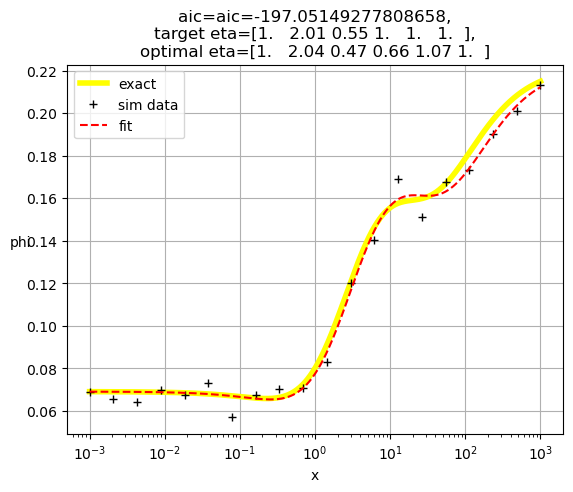

[1.   2.05 0.47 0.72 1.   0.97]


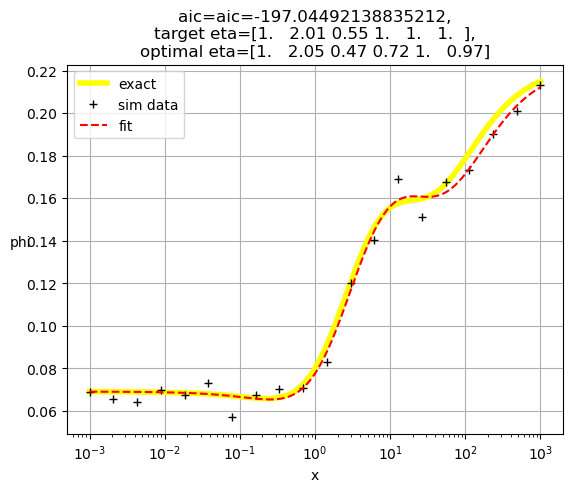

[1.   2.07 0.48 1.   0.68 1.04]


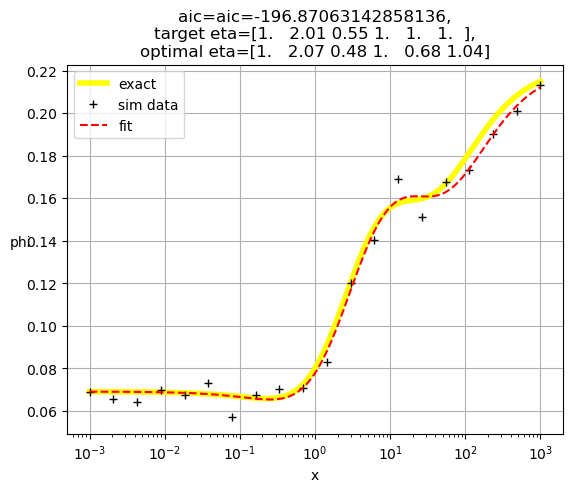

[1.   1.11 1.   0.79 0.87 1.03]


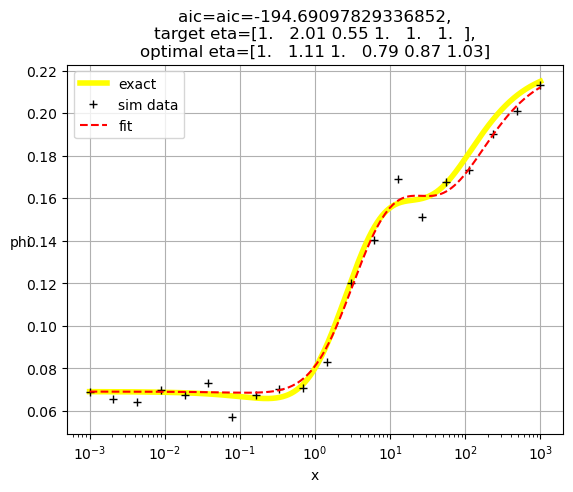

[1.   1.   1.11 0.76 0.87 1.06]


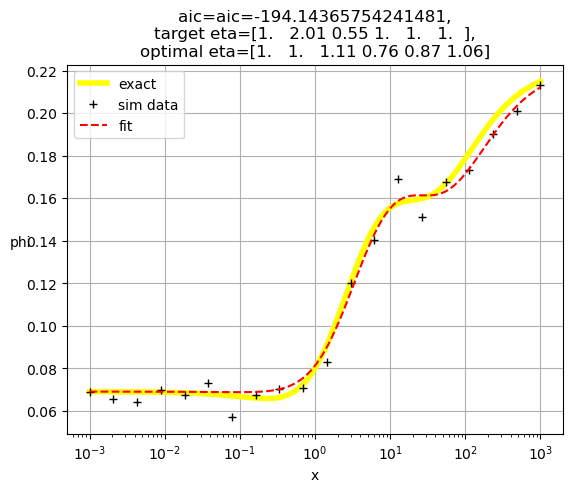

In [12]:
max_depth = 4
d_aic = dict();
Q_aic = copy(Q_directed)
for level in range(max_depth+1,n_eta+1): # delete levels not used
    #print(f'{max_depth=} so deleting {level=}')
    for vert, lev in d_level.items():
        if lev == level:
            Q_aic.delete_vertex(vert)
for level in range(0,max_depth+1):
    for vert, lev in d_level.items():
        if lev == level:
            if Q_aic.has_vertex(vert):
                #print(type(vert))
                aic = do_eta_fit([int(char) for char in vert])
                d_aic[vert]=str(f'{aic:.3f}')
                Q_aic.set_vertex(vert,aic)
                #print(f"level {lev} : eta_mask={vert} {aic=:.2f}")
                hang = 0
                for nv in Q_aic.neighbors_out(vert):
                    #print(f'looking at vert {vert} --> {nv}')
                    if float(d_aic[vert])>=float(d_aic[nv]): # float from str
                        #print(f'deleted edge {vert=} {d_aic[vert]=} -> {nv=} {d_aic[nv]=}')
                        Q_aic.delete_edge(vert,nv)
                    else:
                        hang+=1
                if hang==0 and vert != root:
                    Q_aic.delete_vertex(vert)

In [13]:
print(d_aic)

{'111111': '-199.028', '011111': '-198.669', '101111': '-198.517', '110111': '-197.942', '111011': '-202.247', '111101': '-201.001', '111110': '-198.536', '001111': '-197.481', '010111': '-197.318', '011011': '-202.560', '011101': '-201.399', '011110': '-198.768', '100111': '-197.208', '101011': '-201.090', '101101': '-200.903', '101110': '-199.250', '110011': '-200.542', '110101': '-200.221', '110110': '-198.452', '111001': '-200.278', '111010': '-199.597', '111100': '-198.607', '000111': '-194.594', '001011': '-200.637', '001101': '-200.439', '001110': '-198.680', '010011': '-200.491', '010101': '-200.244', '010110': '-198.447', '011001': '-200.330', '011010': '-199.621', '011100': '-198.708', '100011': '-200.249', '100101': '-200.063', '100110': '-198.316', '101001': '-197.881', '101010': '-197.947', '101100': '-197.804', '110001': '-197.693', '110010': '-197.422', '110100': '-197.170', '111000': '-197.435', '000011': '-197.770', '000101': '-197.567', '000110': '-195.776', '001001':

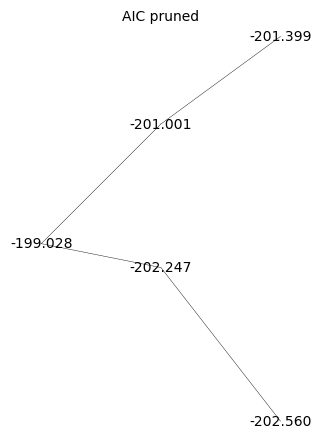

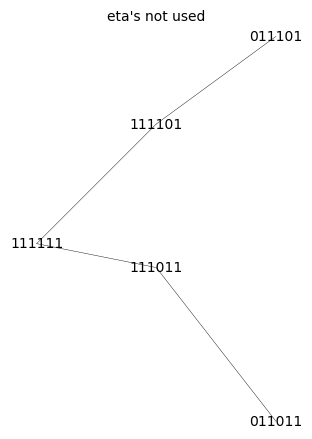

In [14]:
Q_aic_undirected = Q_aic.to_undirected()
Q_aic_undirected.show(figsize=6,edge_labels=False,vertex_labels=d_aic, vertex_size=0,edge_thickness=0.3,vertex_colors='white',title='AIC pruned')
Q_aic_undirected.show(figsize=6,edge_labels=False, vertex_size=0,edge_thickness=0.3,vertex_colors='white',title='eta\'s not used')